<a href="https://colab.research.google.com/github/yatpor/NM-Project-3/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jacobi: Converged after 1834 iterations.


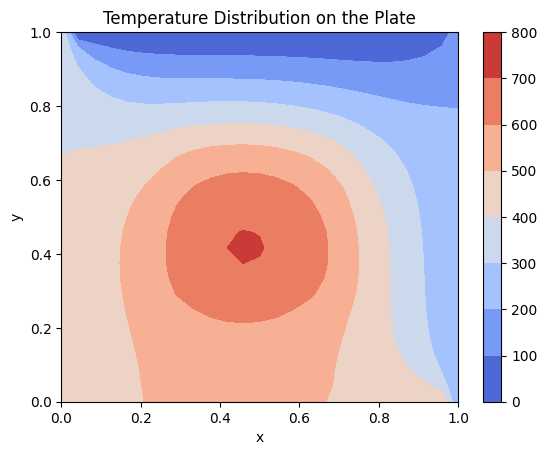

Gauss-Seidel: Converged after 956 iterations.


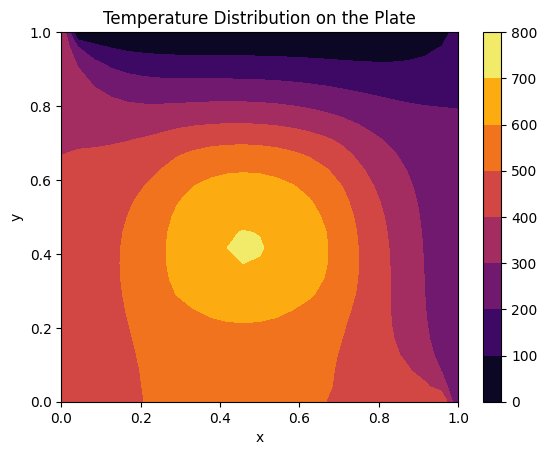

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Define problem parameters
Lx, Ly = 1.0, 1.0  # Plate dimensions
Nx, Ny = 25, 25  # Number of grid points in x and y directions
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)  # Grid spacing

# Create a grid
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)

# Initialize temperature field and heat source
T = np.zeros((Nx, Ny))  # Temperature
Q = np.zeros((Nx, Ny))  # Heat source (you can define your own)

# The region in the middle of the plate is a non-zero heat source
center_x = Nx // 2  # x-coordinate of the center
center_y = Ny // 2  # y-coordinate of the center
side_length = 10  # Size of the square region

# Set the heat source within the defined region
Q[center_x - side_length // 2: center_x + side_length // 2 + 1, center_y - side_length // 2: center_y + side_length // 2 + 1] = -10000.0  # Set source temperature

# Define boundary conditions (homogeneous Dirichlet)
T[0, :] = 500 # Heat applied at bottoom
T[-1, :] = 0  # Top
T[:, 0] = 400  # Left
T[:, -1] = 200  # Right

# Define convergence criteria
max_iterations = 8000
tolerance = 1e-6

# Jacobi Iteration
def jacobi_iteration(T, Q, dx, dy):
    Nx, Ny = T.shape
    T_new = np.copy(T)
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            T_new[i, j] = 0.25 * (T[i+1, j] + T[i-1, j] + T[i, j+1] + T[i, j-1] - dx**2 * Q[i, j])
    return T_new

# Gauss-Seidel Iteration
def gauss_seidel_iteration(T, Q, dx, dy):
    Nx, Ny = T.shape
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            T[i, j] = 0.25 * (T[i+1, j] + T[i-1, j] + T[i, j+1] + T[i, j-1] - dx**2 * Q[i, j])
    return T

# Perform iterations until convergence (Jacobi method)
for iteration in range(max_iterations):
    T_prev = np.copy(T)
    T = jacobi_iteration(T, Q, dx, dy)
    max_diff = np.max(np.abs(T - T_prev))
    if max_diff < tolerance:
        print(f"Jacobi: Converged after {iteration+1} iterations.")
        break

# Visualize the temperature distribution
plt.contourf(x, y, T, cmap='coolwarm')
plt.colorbar()
plt.title("Temperature Distribution on the Plate")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Reset T to zeros for Gauss-Seidel method
T = np.zeros((Nx, Ny))
T[0, :] = 500 # Heat applied at bottoom
T[-1, :] = 0  # Top
T[:, 0] = 400  # Left
T[:, -1] = 200  # Right

# Perform iterations until convergence (Gauss-Seidel method)
for iteration in range(max_iterations):
    T_prev = np.copy(T)
    T = gauss_seidel_iteration(T, Q, dx, dy)
    max_diff = np.max(np.abs(T - T_prev))
    if max_diff < tolerance:
        print(f"Gauss-Seidel: Converged after {iteration+1} iterations.")
        break

# Visualize the temperature distribution
plt.contourf(x, y, T, cmap='inferno') # ='coolwarm')
plt.colorbar()
plt.title("Temperature Distribution on the Plate")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


Tolerance met at 1936 iterations


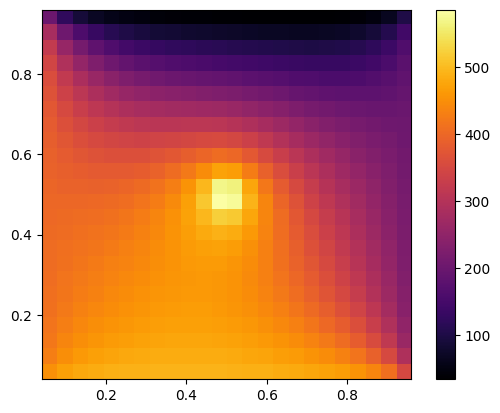

In [21]:
### Numerical Methods Group 3 Final Project ###

## Python package import (these packages must be installed for the script to run) ##

import sys
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy import sparse
import scipy.sparse.linalg
np.set_printoptions(threshold=sys.maxsize)


## 2D Mesh Generation ##

x, y = np.meshgrid(np.linspace(0,1,25+1), np.linspace(0,1,25+1))    # Setting plate size and number of grid points
h = x[0][1] - x[0][0]       # Calculating grid spacing

## Internal Source ##

def f(x, y):

    if x> 0.45 and x<0.55 and y>0.45 and y<0.55: # If you are in small square at center of plate
        source = 100000     # Non-zero source specification

    else:
        source = 0          # Source everywhere else is zero

    return source

## Initial Conditions ##

T = np.zeros(((len(x)-2)*(len(y)-2), 1))    # Creating initial T matrix
T = sparse.csc_matrix(T)                    # Converting T to a sparse matrix (boosts solution efficiency)

## A Matrix Specification ##

A = np.zeros(((len(x)-2)*(len(y)-2), (len(x)-2)*(len(y)-2)))    # Creating initial A matrix

for row in range((len(x)-2)*(len(y)-2)):            # The following conditional statements populate the A matrix with the necessary values
    for column in range((len(x)-2)*(len(y)-2)):
        if column == row:       # Set diagonals
            A[row][column] = 4
        if column == row + 1:       # Consider temperature of node to the right
            A[row][column] = -1
            for i in range((len(x)-2)*(len(y)-2)):
                if column == i*(len(x)-2):      # Unless there is no node to the right
                    A[row][column] = 0
        elif column >= 0 and column == row - 1:     # Consider temperature of node to the left
            A[row][column] = -1
            for i in range((len(x)-2)*(len(y)-2)):
                if column == i*(len(x)-2)-1:        # Unless there is no node to the left
                    A[row][column] = 0
        elif column == row + len(x)-2:      # Consider temperature of node below
            A[row][column] = -1
            if row == max(range((len(x)-2)*(len(y)-2))):        # Unless there is no node below
                A[row][column] = 0
        elif column >= 0 and column == row - (len(x)-2):        # Consider temperature of node above
            A[row][column] = -1
            if row == 0:        # Unless there is no node above
                A[row][column] = 0

A = sparse.csc_matrix(A)        # Converting A matrix to a sparse matrix

## A matrix component breakdown ##

U = -1*sparse.triu(A, k=1)      # Breaking A matrix down into upper triangle (U), lower triangle (L), and diagonal (D) components
L = -1*sparse.tril(A, k=-1)
D = A + U + L

## RHS Matrix + Boundary Conditions ##

b = np.zeros(((len(x)-2)*(len(y)-2), 1))        # Creating initial rhs matrix (boundary conditions + source terms)

Top = 0        # Dirichlet boundary conditions for each wall
Bottom = 500
Left = 400
Right = 200

for i in range(len(b)):     # Populating rhs matrix with boundary conditions
    if i < len(x)-2:
        b[i][0] = Top       # Top boundary temp
    elif i >= (len(x)-2)*(len(y)-2)-len(x)+2:
        b[i][0] = Bottom       # Bottom boundary temp
    for j in range(len(x)-2):
        b[j*(len(x)-2)][0] = Left    # Left boundary temp
    for j in range(len(x)-2):
        b[j*(len(x)-2)-1][0] = Right  # Right boundary temp

for i in range(len(b)):         # Boundary condition corner correction
    if i==0:
        b[i][0] = Top+Left
    elif i == int(max(range(len(b)))):
        b[i][0] = Bottom+Right
    elif i == 0 + int((len(x)-2) -1):
        b[i][0] = Top+Right
    elif i == int(max(range(len(b)))) - int((len(x)-2) -1 ):
        b[i][0] = Bottom+Left

x_2 = []
for i in range(len(x)-2):
    x_2.append(x[i+1][1:-1])

y_2 = []
for i in range(len(y)-2):
    y_2.append(y[i+1][1:-1])

for i in range(len(y_2)):       # Applying internal source (with grid spacing consideration)
    for j in range(len(x_2)):
        b[i*(len(y_2))+j][0] += ((h**2) * f(x_2[i][j], y_2[i][j]))

DmL = D-L

## Solving for final T matrix ##

def Jloop(D, U, L, b, T, iterations):       # Jacobian iteration function

    Q = scipy.sparse.linalg.inv(D)@(L+U)      # Create T (named Q to avoid confusion with temperature)
    c = scipy.sparse.linalg.inv(D)@b          # Create c
    x_init = T      # Initialize temperature
    it = 0          # Initialize iteration count
    tolerance = 1e-6 # set tolerance to 1 x 10exp-6
    tolerance_met = 0

    while (it < iterations) and not(tolerance_met):      # Loop performing Jacobian iteration until specified iteration count is reached
        xnew = Q@x_init + c
        tolerance_met = all(np.abs(xnew-x_init) < tolerance)
        if tolerance_met: print(f'Tolerance met at {it} iterations')
        x_init = xnew
        it += 1

    return xnew     # Returning final solution

def JGSloop(D, U, L, b, T, iterations):       # Gauss-Seidel iteration function

    Q = scipy.sparse.linalg.inv(DmL)@(U)      # Create T (named Q to avoid confusion with temperature)
    c = scipy.sparse.linalg.inv(DmL)@b          # Create c
    x_init = T      # Initialize temperature
    it = 0          # Initialize iteration count
    tolerance = 1e-6 # set tolerance to 1 x 10exp-6
    tolerance_met = 0


    while (it < iterations) and not(tolerance_met):      # Loop performing Gauss Seidel iteration until specified iteration count is reached
        xnew = Q@x_init + c
        tolerance_met = all(np.abs(xnew-x_init) < tolerance)
        if tolerance_met: print(f'Tolerance met at {it} iterations')
        x_init = xnew
        it += 1

    return xnew     # Returning final solution

# iterations = 1000      # iteration count specification

# T = JGSloop(D, U, L, b, T, iterations)        # Temperature solution

# Main Program

iterations = 2000      # iteration count specification

T = Jloop(D, U, L, b, T, iterations)        # Temperature solution


## Plotting (Deactivate if using animation collection section) ##

T_plot = T.reshape((len(x)-2, len(y)-2))      # Reshaping T for contour plotting

fig, axs = plt.subplots()     # Creating figure

axs.imshow(T_plot, cmap = plt.cm.inferno, vmin = np.ndarray.min(T), vmax = np.ndarray.max(T), extent = [x[0][1], x[-1][-2], y[1][0], y[-2][-1]])      # Generating contour
norm = mpl.colors.Normalize(vmin = np.ndarray.min(T), vmax = np.ndarray.max(T))
sm = plt.cm.ScalarMappable(norm=norm, cmap = plt.cm.inferno)
sm.set_array([])
fig.colorbar(ax = axs, mappable = sm)

plt.savefig(str(len(x)-1) + 'x' + str(len(y)-1)+' ('+str(iterations)+' iterations).png')      # Saving image to current working directory


## Animation image collection ##

# for i in range(iterations):        # Jacobian solution loop for animation creation (generates multiple images of solutions using different iteration counts)
#     iterations = i+1
#     T = np.zeros(((len(x)-2)*(len(y)-2), 1))    # Initializing T matrix
#     T = sparse.csc_matrix(T)
#     T = Jloop(D, U, L, b, T, iterations)        # Solving for T for current iteration count
#     T_plot = T.reshape((len(x)-2, len(y)-2))

#     fig, axs = plt.subplots()

#     axs.imshow(T_plot, cmap = plt.cm.inferno, vmin = np.ndarray.min(T), vmax = np.ndarray.max(T), extent = [x[0][1], x[-1][-2], y[0][1], y[-1][-2]])
#     norm = mpl.colors.Normalize(vmin = np.ndarray.min(T), vmax = np.ndarray.max(T))
#     sm = plt.cm.ScalarMappable(norm=norm, cmap = plt.cm.inferno)
#     sm.set_array([])
#     fig.colorbar(ax = axs, mappable = sm)

#     plt.savefig(str(len(x)-1) + 'x' + str(len(y)-1)+' ('+str(iterations)+' iterations).png')
#     plt.close(fig)